In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import optuna

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor, VotingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [ ]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
train.shape

(1460, 81)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
missing_values = train.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
missing_values
# missing_columns

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

In [ ]:
train.drop('Id', axis=1).duplicated().sum()

0

In [ ]:
cat_features = train.select_dtypes(include=['object']).columns.tolist()
num_features = train.drop(['Id', 'SalePrice'], axis=1).select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical columns:\n{cat_features}")
print(f"\nNumerical columns:\n{num_features}")

Categorical columns:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

Numerical columns:
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageAr

In [ ]:
train[num_features].describe().style.set_table_attributes(
    'style="overflow-x: auto; display: inline-block;"').set_properties(**{'min-width': '100px'})

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [ ]:
Q1 = train[num_features].quantile(0.25)
Q3 = train[num_features].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = ((train[num_features] < lower_bound) | (train[num_features] > upper_bound))

outliers_count = outliers_iqr.sum()
outliers_count = outliers_count[outliers_count > 0].sort_values(ascending=False)
print(f"Outliers Count: \n{outliers_count}")

Outliers Count: 
EnclosedPorch    208
BsmtFinSF2       167
OverallCond      125
ScreenPorch      116
MSSubClass       103
MasVnrArea        96
LotFrontage       88
BsmtHalfBath      82
OpenPorchSF       77
LotArea           69
KitchenAbvGr      68
TotalBsmtSF       61
MiscVal           52
BedroomAbvGr      35
WoodDeckSF        32
GrLivArea         31
TotRmsAbvGrd      30
BsmtUnfSF         29
LowQualFinSF      26
3SsnPorch         24
GarageArea        21
1stFlrSF          20
YearBuilt          7
PoolArea           7
BsmtFinSF1         7
GarageCars         5
Fireplaces         5
OverallQual        2
2ndFlrSF           2
BsmtFullBath       1
dtype: int64


In [ ]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

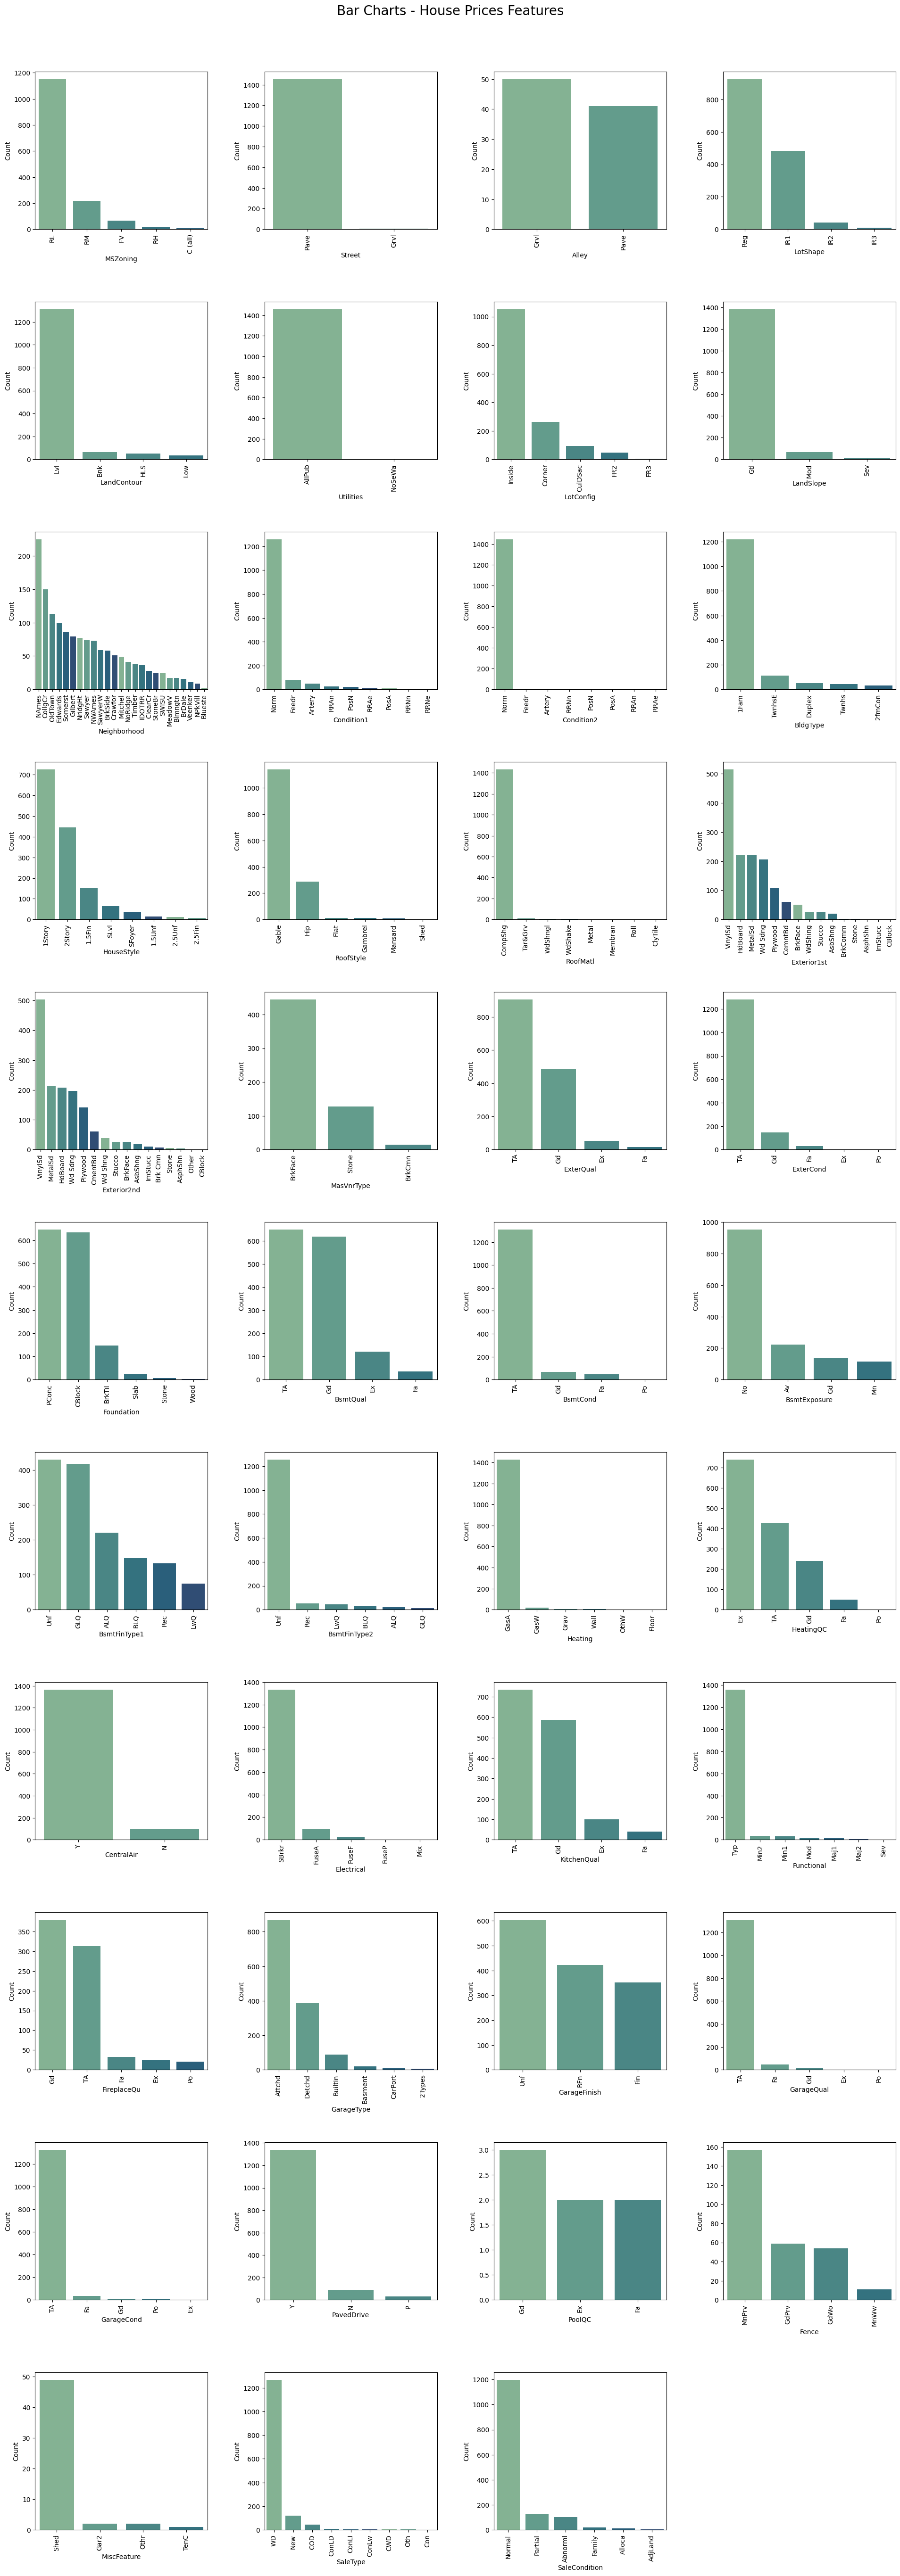

In [ ]:
n_rows = 11
n_cols = 4
palette = sns.color_palette("crest")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))

for i, column in enumerate(train[cat_features].columns):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    category_counts = train[cat_features][column].value_counts()
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax, palette=palette)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=90)
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.suptitle('Bar Charts - House Prices Features', fontsize=20, y=1.0)
plt.tight_layout(pad=4.0)
plt.savefig('Bar Charts - House Prices Features.png')
plt.show()

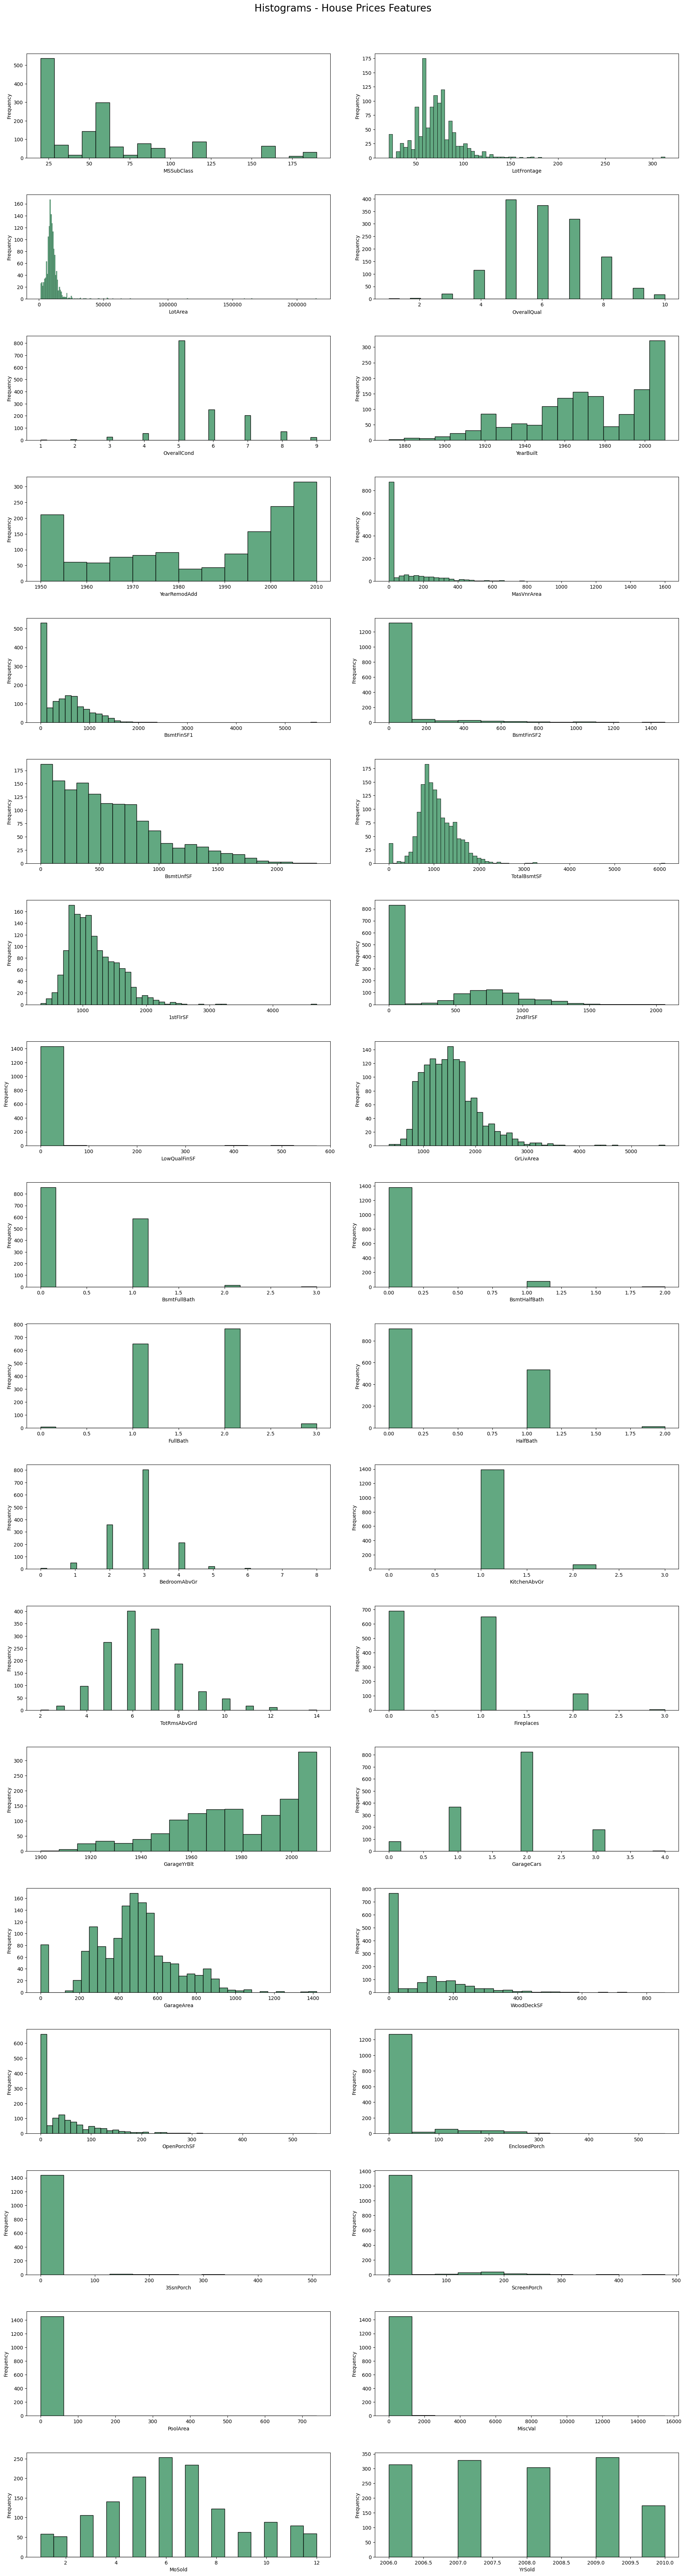

In [ ]:
n_cols = 2
n_rows = 18

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))

for i, column in enumerate(train[num_features].columns):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    sns.histplot(train[num_features][column], ax=ax, color='seagreen')
    ax.set_ylabel('Frequency')

plt.suptitle('Histograms - House Prices Features', fontsize=20, y=1.0)
plt.tight_layout(pad=4.0)
plt.savefig('Histograms - House Prices Features.png')
plt.show()

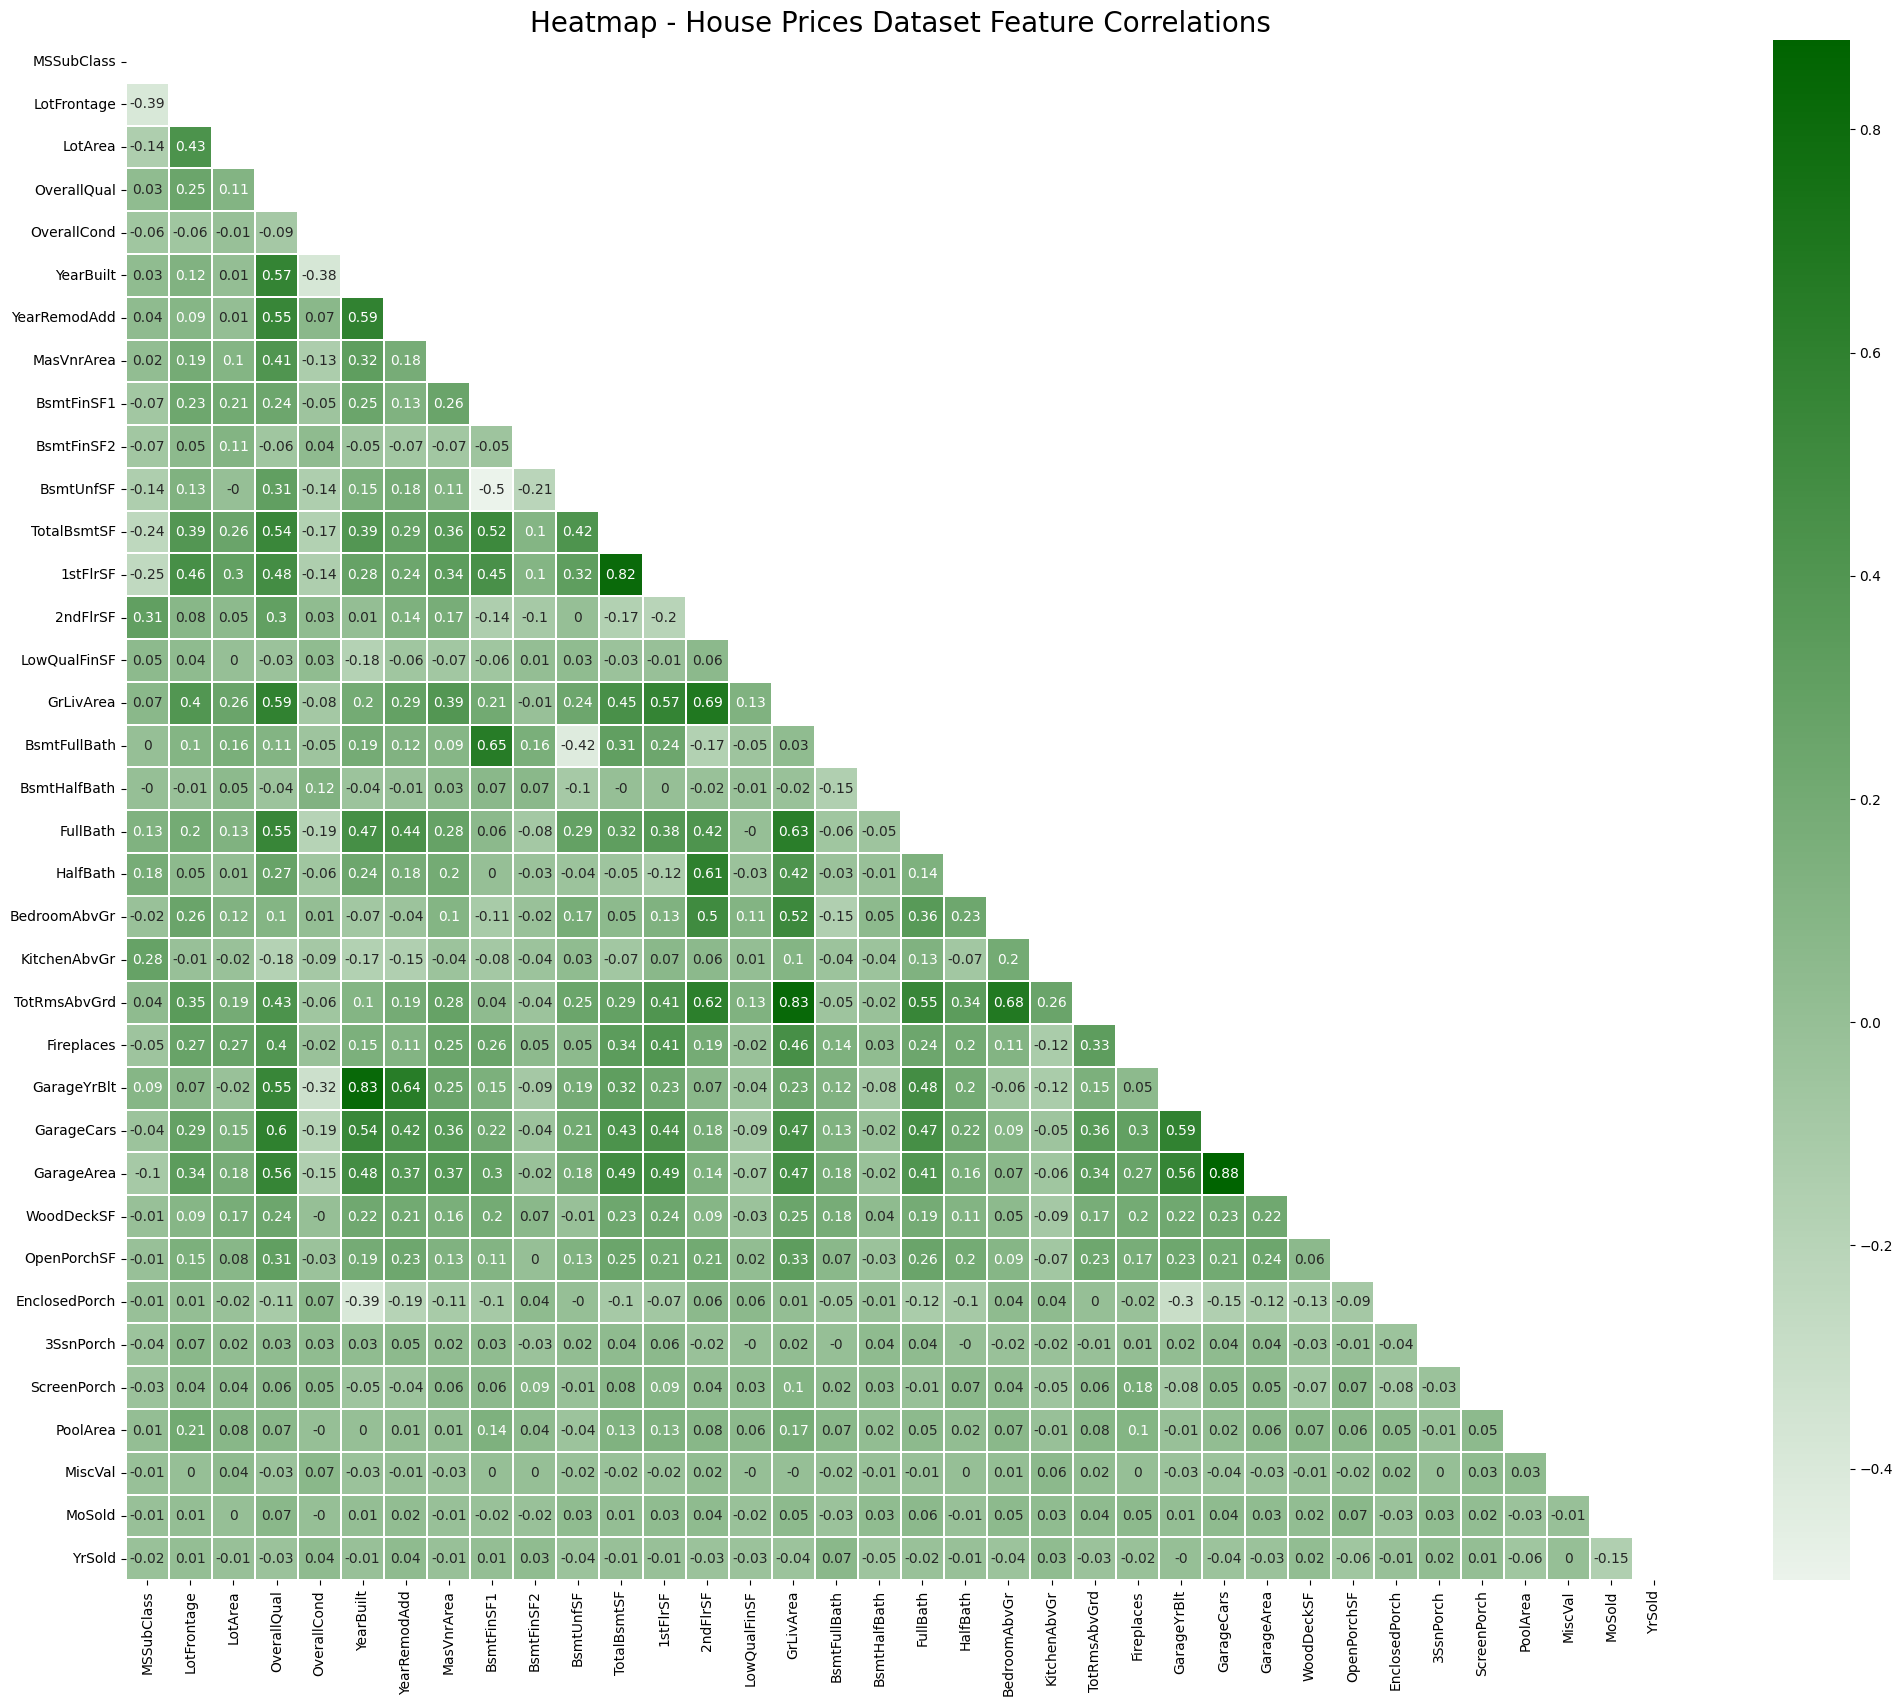

In [ ]:
corr = train[num_features].corr().round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.light_palette("darkgreen", as_cmap=True)

plt.figure(figsize=(25,20))
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, linewidths=0.2)

plt.title('Heatmap - House Prices Dataset Feature Correlations', fontsize=20)

plt.savefig('House Prices Dataset Feature Correlations.png')
plt.show()

In [ ]:
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)

In [ ]:
numerical_cols = num_features.copy()
categorical_cols = cat_features.copy()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler())
        ]), numerical_cols),
        ('categorical', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), categorical_cols)
    ],
    remainder='passthrough'
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['MSSubClass', 'LotFrontage', 'LotArea',
                                  'OverallQual', 'OverallCond', 'YearBuilt',
                                  'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
                                  'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                                  '1stFlrSF', '2ndFlrSF', 'LowQualFinS...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'Neighborhood', 'Condition1',
                                  'Condition2', 'BldgType', 'HouseStyle',
                                  'RoofStyle', 'RoofMatl', 'Exterior1st',
                                  'Exterior2nd', 'MasVnrType', 'ExterQual',
                                  'ExterCond', 'Foundation', 'BsmtQual',
                                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', ...])])

In [ ]:
X = train.drop(columns=['SalePrice'])
y = train['SalePrice']

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(random_state=42),
    'Bagging Regressor': BaggingRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Extreme Gradient Boosting': XGBRegressor(random_state=42),
}

In [ ]:
def train_models(X, y, models, preprocessor):
    results = {}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    for name, model in models.items():
        pipeline = make_pipeline(preprocessor, model)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(1)
        print(f'Mean Absolute Error - {name}:\n{mae}')
        results[name] = mae
    return results
results = train_models(X, y, models, preprocessor)

Mean Absolute Error - Linear Regression:
19931.2
Mean Absolute Error - Lasso:
19839.4
Mean Absolute Error - Ridge:
19719.9
Mean Absolute Error - ElasticNet:
20760.6
Mean Absolute Error - Bagging Regressor:
19565.6
Mean Absolute Error - Random Forest:
17575.7
Mean Absolute Error - Extreme Gradient Boosting:
18297.7


In [ ]:
def objective(trial, X_train, y_train):

    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    pipeline = make_pipeline(preprocessor, model)
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()

    return -score



X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)

print("Best hyperparameters: ", study.best_params)

best_rf = RandomForestRegressor(
    **study.best_params,
    random_state=42
)
pipeline = make_pipeline(preprocessor, best_rf)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

val_score = mean_absolute_error(y_val, y_pred).round(1)
print("Validation Set MAE:", val_score)

[I 2024-07-21 19:14:27,314] A new study created in memory with name: no-name-f856ac63-9a2f-4899-9c09-54969bc62423
[I 2024-07-21 19:14:30,513] Trial 0 finished with value: 20773.403108227947 and parameters: {'n_estimators': 177, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 20773.403108227947.
[I 2024-07-21 19:14:34,321] Trial 1 finished with value: 18531.997193855943 and parameters: {'n_estimators': 166, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 18531.997193855943.
[I 2024-07-21 19:14:37,502] Trial 2 finished with value: 18645.874401760146 and parameters: {'n_estimators': 142, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 18531.997193855943.
[I 2024-07-21 19:14:38,686] Trial 3 finished with value: 23458.199950117683 and parameters: {'n_estimators': 85, 'max_depth': 9, 'min

Best hyperparameters:  {'n_estimators': 157, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Validation Set MAE: 17739.4


In [ ]:
best_rf

RandomForestRegressor(max_depth=22, max_features='sqrt', n_estimators=157,
                      random_state=42)

In [ ]:
def objective(trial, X_train, y_train):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 20),
        'subsample': trial.suggest_loguniform('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.05, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'random_state': 42
    }

    model = XGBRegressor(**params)

    pipeline = make_pipeline(preprocessor, model)

    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()

    return -score
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=150)

print("Best hyperparameters: ", study.best_params)

best_xgb = XGBRegressor(
    **study.best_params,
    device='gpu'
)

pipeline = make_pipeline(preprocessor, best_xgb)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

val_score = mean_absolute_error(y_val, y_pred).round(1)
print("Validation Set MAE:", val_score)

[I 2024-07-21 19:20:03,421] A new study created in memory with name: no-name-40d0f3f9-bae4-4070-ba6f-e9f08a4631eb
[I 2024-07-21 19:20:03,940] Trial 0 finished with value: 43354.951204559635 and parameters: {'n_estimators': 59, 'learning_rate': 0.022135756814854187, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.27744416313576303, 'colsample_bytree': 0.05016163823226578, 'gamma': 0.06862453292443224, 'reg_alpha': 3.119105439173417e-05, 'reg_lambda': 1.373625649567081e-06}. Best is trial 0 with value: 43354.951204559635.
[I 2024-07-21 19:20:04,879] Trial 1 finished with value: 29515.052564704383 and parameters: {'n_estimators': 172, 'learning_rate': 0.009218442416937814, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5370590435433739, 'colsample_bytree': 0.0807752752846009, 'gamma': 3.33139919288956e-05, 'reg_alpha': 0.0032500004649659233, 'reg_lambda': 0.012799590760067482}. Best is trial 1 with value: 29515.052564704383.
[I 2024-07-21 19:20:06,294] Trial 2 finished with v

Best hyperparameters:  {'n_estimators': 190, 'learning_rate': 0.053299023170743316, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.7731923285600943, 'colsample_bytree': 0.5462183445132, 'gamma': 9.72610532853428e-08, 'reg_alpha': 2.285386635652749e-05, 'reg_lambda': 0.019208147241007466}
Validation Set MAE: 16095.5


In [ ]:
best_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5462183445132, device='gpu',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=9.72610532853428e-08,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.053299023170743316,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=190, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

base_learners = [
    ('Random Forest', best_rf),
    ('Extreme Gradient Boosting', best_xgb)
]

stacking_regressor = StackingRegressor(
    estimators=base_learners,
    final_estimator=Ridge()
)

pipeline = make_pipeline(preprocessor, stacking_regressor)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred).round(1)
print(f"Mean Absolute Error: {mae}")
stacking_regressor



Mean Absolute Error: 16146.9


StackingRegressor(estimators=[('Random Forest',
                               RandomForestRegressor(max_depth=22,
                                                     max_features='sqrt',
                                                     n_estimators=157,
                                                     random_state=42)),
                              ('Extreme Gradient Boosting',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5462183445132,
                                            device='gpu',
                                            early_stopping_rounds=None,
                                            enable_categ...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.053299023170743316,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None, min_child_weight=3,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=190, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                  final_estimator=Ridge())

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

base_learners = [
    ('Random Forest', best_rf),
    ('Extreme Gradient Boosting', best_xgb)
]

voting_regressor = VotingRegressor(estimators=base_learners)

pipeline = make_pipeline(preprocessor, voting_regressor)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

mae = mean_absolute_error(y_val, y_pred).round(1)
print(f"Mean Absolute Error: {mae}")

voting_regressor


Mean Absolute Error: 16301.8


VotingRegressor(estimators=[('Random Forest',
                             RandomForestRegressor(max_depth=22,
                                                   max_features='sqrt',
                                                   n_estimators=157,
                                                   random_state=42)),
                            ('Extreme Gradient Boosting',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.5462183445132,
                                          device='gpu',
                                          early_stopping_rounds=None,
                                          enable_categor...
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.053299023170743316,
                                          max_bin=None, max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=4,
                                          max_leaves=None, min_child_weight=3,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=190,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=None, ...))])

In [ ]:
pipeline = make_pipeline(preprocessor, best_rf)
pipeline = make_pipeline(preprocessor, stacking_regressor)
pipeline = make_pipeline(preprocessor, voting_regressor)
pipeline = make_pipeline(preprocessor, best_xgb)
test_predictions = pipeline.predict(test)
test_predictions

array([128903.86, 151926.86, 185702.22, ..., 177295.2 , 121374.03,
       226264.94], dtype=float32)